<a href="https://colab.research.google.com/github/hamasakram/Developers-Corporation-AI-Internship/blob/main/Credit_Risk_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from datetime import datetime

In [ ]:
data = pd.read_csv("/kaggle/input/credit-risk-dataset/loan/loan.csv", low_memory=False)
data.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m
0,1077501,1296599,5000.0,5000.0,4975.0,36 months,10.65,162.87,B,B2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1077430,1314167,2500.0,2500.0,2500.0,60 months,15.27,59.83,C,C4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1077175,1313524,2400.0,2400.0,2400.0,36 months,15.96,84.33,C,C5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1076863,1277178,10000.0,10000.0,10000.0,36 months,13.49,339.31,C,C1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1075358,1311748,3000.0,3000.0,3000.0,60 months,12.69,67.79,B,B5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Remove columns with >90% missing values

In [ ]:
del_columns = []
for col in data.columns:
    if (data[col].isnull().sum() / len(data) * 100) > 90:
        del_columns.append(col)

data = data.drop(columns=del_columns)

### Remove ID columns

In [ ]:
id_columns = ["id", "member_id"]
data = data.drop(columns=id_columns)

In [ ]:
feat_arr = ["addr_state", "zip_code"]
print(data[feat_arr].describe())
for col in feat_arr:
    print(f"missing % {col}:", data[col].isnull().sum() / len(data) * 100)

data["2_digit_zip"] = data["zip_code"].apply(lambda x: int(x[:2]))
data = data.drop(columns=["addr_state", "zip_code"])

       addr_state zip_code
count      887379   887379
unique         51      935
top            CA    945xx
freq       129517     9770
missing % addr_state: 0.0
missing % zip_code: 0.0


#### Employment and income related features
- annual_inc
- verification_status
- emp_length
- emp_title

Let's remove the employment title as we already have the annual income feature.\
The emp_length needs to be cleaned and converted to numerical feature.\
We fill the missing values using mean imputation and encode the verification_status feature.

In [ ]:
feat_arr_num = ["annual_inc"]
feat_arr_cat = ["verification_status", "emp_length", "emp_title"]
print(data[feat_arr_num].describe())
print(data[feat_arr_cat].describe())
for col in feat_arr_num+feat_arr_cat:
    print(f"missing % {col}:", data[col].isnull().sum() / len(data) * 100)

         annual_inc
count  8.873750e+05
mean   7.502759e+04
std    6.469830e+04
min    0.000000e+00
25%    4.500000e+04
50%    6.500000e+04
75%    9.000000e+04
max    9.500000e+06
       verification_status emp_length emp_title
count               887379     842554    835917
unique                   3         11    299271
top        Source Verified  10+ years   Teacher
freq                329558     291569     13469
missing % annual_inc: 0.00045076568185634325
missing % verification_status: 0.0
missing % emp_length: 5.051392922302647
missing % emp_title: 5.799325879922783


In [ ]:
def clean_emp_length(x):
    if pd.isna(x): return None
    if x.strip().lower()=="< 1 year": return 0
    elif x.strip().lower()=="1 year": return 1
    elif x.strip().lower()=="10+ years": return 11
    else: return int(x.rstrip("years").strip())

data["emp_length"] = data["emp_length"].apply(clean_emp_length)
data["emp_length"] = data["emp_length"].fillna(value=data["emp_length"].mean())

data["annual_inc"] = data["annual_inc"].fillna(value=data["annual_inc"].mean())

le = LabelEncoder()
data['verification_status'] = le.fit_transform(data['verification_status'])

data = data.drop(columns=["emp_title"])

In [ ]:
feat_arr_cat = ["purpose", "initial_list_status", "issue_d"]
print(data[feat_arr_cat].describe())
for col in feat_arr_cat:
    print(f"missing % {col}:", data[col].isnull().sum() / len(data) * 100)

                   purpose initial_list_status   issue_d
count               887379              887379    887379
unique                  14                   2       103
top     debt_consolidation                   f  Oct-2015
freq                524215              456848     48631
missing % purpose: 0.0
missing % initial_list_status: 0.0
missing % issue_d: 0.0


In [ ]:
le = LabelEncoder()
data['purpose'] = le.fit_transform(data['purpose'])
data['initial_list_status'] = le.fit_transform(data['initial_list_status'])

def compute_time_since(x):
    if pd.isna(x): return None
    given_date = datetime.strptime(x, "%b-%Y")
    current_date = datetime.now()
    return (current_date - given_date).days / 365.25

data["issue_d"] = data["issue_d"].apply(compute_time_since)

data = data.drop(columns=["desc", "title", "url", "policy_code", "application_type"])

In [ ]:
feat_arr_num = ["loan_amnt", "int_rate", "installment", "funded_amnt", "funded_amnt_inv",
"total_pymnt", "total_pymnt_inv", "last_pymnt_amnt", "total_rec_late_fee"]
data[feat_arr_num].describe()

,loan_amnt,int_rate,installment,funded_amnt,funded_amnt_inv,total_pymnt,total_pymnt_inv,last_pymnt_amnt,total_rec_late_fee
count,887379.000000,887379.000000,887379.000000,887379.000000,887379.000000,887379.000000,887379.000000,887379.000000,887379.000000
mean,14755.264605,13.246740,436.717127,14741.877625,14702.464383,7558.826684,7521.160306,2164.145585,0.396692
std,8435.455601,4.381867,244.186593,8429.897657,8442.106732,7871.243336,7846.108604,4794.783233,4.087825
min,500.000000,5.320000,15.670000,500.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,8000.000000,9.990000,260.705000,8000.000000,8000.000000,1914.590000,1899.700000,280.170000,0.000000
50%,13000.000000,12.990000,382.550000,13000.000000,13000.000000,4894.999117,4862.010000,462.780000,0.000000
75%,20000.000000,16.200000,572.600000,20000.000000,20000.000000,10616.814231,10565.690000,831.245000,0.000000
max,35000.000000,28.990000,1445.460000,35000.000000,35000.000000,57777.579870,57777.580000,36475.590000,358.680000


In [ ]:
feat_arr_cat = ["term", "last_pymnt_d"]
data[feat_arr_cat].describe()

,term,last_pymnt_d
count,887379,869720
unique,2,98
top,36 months,Jan-2016
freq,621125,470150


In [ ]:
for col in feat_arr_cat+feat_arr_num:
    print(f"missing % {col}:", data[col].isnull().sum() / len(data) * 100)

missing % term: 0.0
missing % last_pymnt_d: 1.9900177939752912
missing % loan_amnt: 0.0
missing % int_rate: 0.0
missing % installment: 0.0
missing % funded_amnt: 0.0
missing % funded_amnt_inv: 0.0
missing % total_pymnt: 0.0
missing % total_pymnt_inv: 0.0
missing % last_pymnt_amnt: 0.0
missing % total_rec_late_fee: 0.0


In [ ]:
le = LabelEncoder()
data['term'] = le.fit_transform(data['term'])

data["last_pymnt_d"] = data["last_pymnt_d"].apply(compute_time_since)
data["last_pymnt_d"] = data["last_pymnt_d"].fillna(value=data["last_pymnt_d"].mean())

data = data.drop(columns=["total_rec_int", "total_rec_prncp", "out_prncp", "out_prncp_inv", "pymnt_plan"])

In [ ]:
feat_arr_num = ["dti","earliest_cr_line","delinq_2yrs","collections_12_mths_ex_med",
"inq_last_6mths","total_rev_hi_lim","acc_now_delinq","tot_coll_amt","tot_cur_bal",
"last_credit_pull_d","open_acc","total_acc","mths_since_last_delinq",
"mths_since_last_major_derog","mths_since_last_record","pub_rec","revol_bal","revol_util"]
data[feat_arr_num].describe()

,dti,delinq_2yrs,collections_12_mths_ex_med,inq_last_6mths,total_rev_hi_lim,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc,total_acc,mths_since_last_delinq,mths_since_last_major_derog,mths_since_last_record,pub_rec,revol_bal,revol_util
count,887379.000000,887350.000000,887234.000000,887350.000000,8.171030e+05,887350.000000,8.171030e+05,8.171030e+05,887350.000000,887350.000000,433067.000000,221703.000000,137053.000000,887350.000000,8.873790e+05,886877.000000
mean,18.157039,0.314442,0.014380,0.694623,3.206862e+04,0.004991,2.257026e+02,1.394582e+05,11.548469,25.268026,34.063798,44.104838,70.117903,0.195307,1.692079e+04,55.067693
std,17.190626,0.862244,0.134191,0.998448,3.749826e+04,0.077625,1.031137e+04,1.537500e+05,5.317313,11.840561,21.884940,22.179841,28.127914,0.582091,2.242679e+04,23.834344
min,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000
25%,11.910000,0.000000,0.000000,0.000000,1.390000e+04,0.000000,0.000000e+00,2.985300e+04,8.000000,17.000000,15.000000,27.000000,51.000000,0.000000,6.443000e+03,37.700000
50%,17.650000,0.000000,0.000000,0.000000,2.370000e+04,0.000000,0.000000e+00,8.055900e+04,11.000000,24.000000,31.000000,44.000000,70.000000,0.000000,1.187500e+04,56.000000
75%,23.950000,0.000000,0.000000,1.000000,3.980000e+04,0.000000,0.000000e+00,2.082050e+05,14.000000,32.000000,50.000000,61.000000,92.000000,0.000000,2.082900e+04,73.600000
max,9999.000000,39.000000,20.000000,33.000000,9.999999e+06,14.000000,9.152545e+06,8.000078e+06,90.000000,169.000000,188.000000,188.000000,129.000000,86.000000,2.904836e+06,892.300000


In [ ]:
feat_arr_cat = ["earliest_cr_line", "last_credit_pull_d"]
data[feat_arr_cat].describe()

,earliest_cr_line,last_credit_pull_d
count,887350,887326
unique,697,103
top,Aug-2001,Jan-2016
freq,6659,730574


In [ ]:
for col in feat_arr_cat+feat_arr_num:
    print(f"missing % {col}:", data[col].isnull().sum() / len(data) * 100)

missing % earliest_cr_line: 0.0032680511934584885
missing % last_credit_pull_d: 0.005972645284596547
missing % dti: 0.0
missing % earliest_cr_line: 0.0032680511934584885
missing % delinq_2yrs: 0.0032680511934584885
missing % collections_12_mths_ex_med: 0.016340255967292442
missing % inq_last_6mths: 0.0032680511934584885
missing % total_rev_hi_lim: 7.919502264534094
missing % acc_now_delinq: 0.0032680511934584885
missing % tot_coll_amt: 7.919502264534094
missing % tot_cur_bal: 7.919502264534094
missing % last_credit_pull_d: 0.005972645284596547
missing % open_acc: 0.0032680511934584885
missing % total_acc: 0.0032680511934584885
missing % mths_since_last_delinq: 51.19706461387975
missing % mths_since_last_major_derog: 75.01597400885078
missing % mths_since_last_record: 84.55530275113566
missing % pub_rec: 0.0032680511934584885
missing % revol_bal: 0.0
missing % revol_util: 0.05657109307297107


In [ ]:
data["earliest_cr_line"] = data["earliest_cr_line"].apply(compute_time_since)
data["last_credit_pull_d"] = data["last_credit_pull_d"].apply(compute_time_since)

data[feat_arr_num] = data[feat_arr_num].fillna(data[feat_arr_num].mean())
data[feat_arr_cat] = data[feat_arr_cat].fillna(data[feat_arr_cat].mean())

#### Loan grade related features
- grade
- sub_grade

We keep both features and encode them.

In [ ]:
le = LabelEncoder()
data['grade'] = le.fit_transform(data['grade'])
data['sub_grade'] = le.fit_transform(data['sub_grade'])

#### Home ownership related feature
- home_ownership

We keep this feature and encode it.

In [ ]:
le = LabelEncoder()
data['home_ownership'] = le.fit_transform(data['home_ownership'])

In [ ]:
data = data.drop(columns=["collection_recovery_fee", "recoveries", "next_pymnt_d"])

### Target class distribution

<Axes: xlabel='count', ylabel='loan_status'>

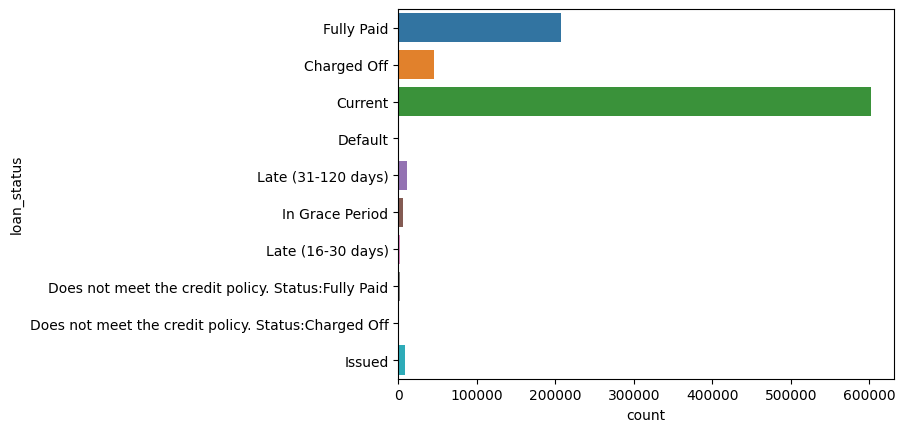

In [ ]:
sns.countplot(data=data, y="loan_status")

### Binarize the target
- 0: fully paid, current, etc.
- 1: charged off, late, etc.


<Axes: xlabel='count', ylabel='target'>

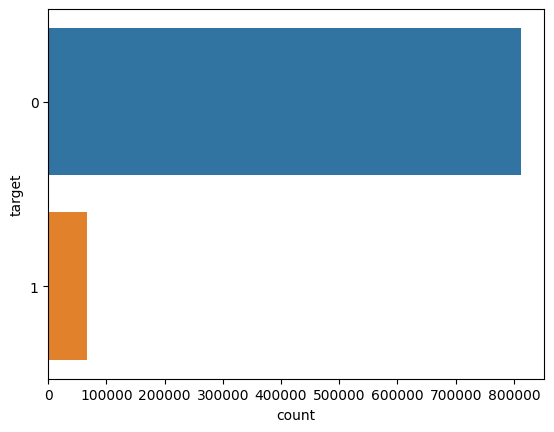

In [ ]:
def binarize_target(loan_status):
    cat_0_words = ["paid", "current"]
    cat_1_words = ["charged off", "late", "default", "grace period"]
    for word in cat_0_words:
        if loan_status.lower().find(word)!=-1: return 0
    for word in cat_1_words:
        if loan_status.lower().find(word)!=-1: return 1
    return -1

data["target"] = data["loan_status"].apply(binarize_target)
data = data[data["target"]!=-1]
sns.countplot(data=data, y="target")

### Moleding

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

X = data.drop(columns=["loan_status", "target"])
y = data[["target"]]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=131543)

rf = RandomForestClassifier(
    n_estimators=500,
    criterion='gini',
    max_depth=5,
    min_samples_split=2,
    min_samples_leaf=1,
    max_leaf_nodes=None,
    bootstrap=True,
    oob_score=False,
    random_state=131543,
    n_jobs=-1,
    warm_start=False,
    class_weight="balanced"
)

rf.fit(X_train, y_train.values.ravel())

RandomForestClassifier(class_weight='balanced', max_depth=5, n_estimators=500,
                       n_jobs=-1, random_state=131543)

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
print("Accuracy: ", accuracy_score(y_test, rf.predict(X_test)))
print("Precision: ", precision_score(y_test, rf.predict(X_test)))
print("Recall: ", recall_score(y_test, rf.predict(X_test)))
print("F1-score: ", f1_score(y_test, rf.predict(X_test)))
print("ROC AUC: ", roc_auc_score(y_test, rf.predict(X_test)))

Accuracy:  0.910151094525099
Precision:  0.45844514153974075
Recall:  0.8922397940419272
F1-score:  0.6056823288560443
ROC AUC:  0.9019461244469912
